In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

In [2]:
### READ DATASET ###
df = pd.read_csv('./avocado.csv', index_col=0, parse_dates=['Date'])
df.sort_values('Date', inplace=True)

print(df.shape)
df.head()

(18249, 13)


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [3]:
### PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE ###
def plot_seris(county, typ):
    
    plt.figure(figsize=(9,6))
    reg_train = df[(df['type']==typ)&(df['year']!=2018)].groupby('region')
    p_train = reg_train.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(0,len(p_train)), p_train.AveragePrice.values)
    
    reg_test = df[(df['type']==typ)&(df['year']==2018)].groupby('region')
    p_test = reg_test.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(len(p_train),len(p_train)+len(p_test)),p_test.AveragePrice.values)
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

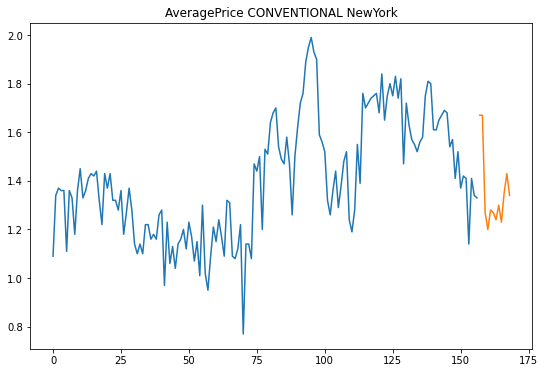

In [4]:
plot_seris('NewYork','conventional')

In [5]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###
sequence_length = 4

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### CREATE TRAIN/TEST PRICE DATA ###
X_train_c, X_train_o = [], []
X_test_c, X_test_o = [], []
X_other_train_c, X_other_train_o = [], []
X_other_test_c, X_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                                 sequence_length, ['AveragePrice']):
        X_train_c.append(sequence) if county != 'Albany' else X_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, ['AveragePrice']):
        X_train_o.append(sequence) if county != 'Albany' else X_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_c.append(sequence) if county != 'Albany' else X_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_o.append(sequence) if county != 'Albany' else X_other_test_o.append(sequence)
    
X_train_c, X_train_o = np.asarray(X_train_c), np.asarray(X_train_o)
X_test_c, X_test_o = np.asarray(X_test_c), np.asarray(X_test_o)
X_other_train_c, X_other_train_o = np.asarray(X_other_train_c), np.asarray(X_other_train_o)
X_other_test_c, X_other_test_o = np.asarray(X_other_test_c), np.asarray(X_other_test_o)

In [7]:
### CREATE TRAIN/TEST LABEL ###
y_train_c, y_train_o = [], []
y_test_c, y_test_o = [], []
y_other_train_c, y_other_train_o = [], []
y_other_test_c, y_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_c.append(sequence) if county != 'Albany' else y_other_train_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_o.append(sequence) if county != 'Albany' else y_other_train_o.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_c.append(sequence) if county != 'Albany' else y_other_test_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_o.append(sequence) if county != 'Albany' else y_other_test_o.append(sequence)

y_train_c, y_train_o = np.asarray(y_train_c), np.asarray(y_train_o)
y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
y_other_train_c, y_other_train_o = np.asarray(y_other_train_c), np.asarray(y_other_train_o)
y_other_test_c, y_other_test_o = np.asarray(y_other_test_c), np.asarray(y_other_test_o)

In [8]:
### CONCATENATE TRAIN/TEST DATA AND LABEL ### 
X = np.concatenate([X_train_c,X_train_o,X_test_c,X_test_o],axis=0)
y = np.concatenate([y_train_c,y_train_o,y_test_c,y_test_o],axis=0)

print(X.shape,y.shape)

(17063, 4, 1) (17063, 1)


In [9]:
### CREATE TRAIN/TEST EXTERNAL FEATURES ###
col = ['Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags']

f_train_c, f_train_o = [], []
f_test_c, f_test_o = [], []
f_other_train_c, f_other_train_o = [], []
f_other_test_c, f_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_c.append(sequence) if county != 'Albany' else f_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_o.append(sequence) if county != 'Albany' else f_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_c.append(sequence) if county != 'Albany' else f_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_o.append(sequence) if county != 'Albany' else f_other_test_o.append(sequence)
    
f_train_c, f_train_o = np.asarray(f_train_c), np.asarray(f_train_o)
f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)
f_other_train_c, f_other_train_o = np.asarray(f_other_train_c), np.asarray(f_other_train_o)
f_other_test_c, f_other_test_o = np.asarray(f_other_test_c), np.asarray(f_other_test_o)

In [10]:
### CONCATENATE TRAIN/TEST EXTERNAL FEATURES ###
F = np.concatenate([f_train_c,f_train_o,f_test_c,f_test_o],axis=0)

print(F.shape)

(17063, 4, 8)


# FORECASTER + AUTOENCODER

In [11]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE LSTM AUTOENCODER ###
inputs_ae = Input(shape=(sequence_length, 1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.3)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.3)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])

### TRAIN AUTOENCODER ###
sequence_autoencoder.fit(X[:len(X_train_c)+len(X_train_o)], X[:len(X_train_c)+len(X_train_o)], 
                         batch_size=128, epochs=100, verbose=2, shuffle=True)

Epoch 1/100
127/127 - 1s - loss: 0.5307 - mse: 0.5316
Epoch 2/100
127/127 - 1s - loss: 0.1474 - mse: 0.1475
Epoch 3/100
127/127 - 1s - loss: 0.1097 - mse: 0.1098
Epoch 4/100
127/127 - 1s - loss: 0.0738 - mse: 0.0738
Epoch 5/100
127/127 - 2s - loss: 0.0563 - mse: 0.0562
Epoch 6/100
127/127 - 1s - loss: 0.0462 - mse: 0.0462
Epoch 7/100
127/127 - 1s - loss: 0.0421 - mse: 0.0420
Epoch 8/100
127/127 - 1s - loss: 0.0386 - mse: 0.0386
Epoch 9/100
127/127 - 1s - loss: 0.0362 - mse: 0.0362
Epoch 10/100
127/127 - 1s - loss: 0.0335 - mse: 0.0335
Epoch 11/100
127/127 - 1s - loss: 0.0325 - mse: 0.0325
Epoch 12/100
127/127 - 1s - loss: 0.0316 - mse: 0.0316
Epoch 13/100
127/127 - 1s - loss: 0.0308 - mse: 0.0307
Epoch 14/100
127/127 - 1s - loss: 0.0310 - mse: 0.0310
Epoch 15/100
127/127 - 1s - loss: 0.0288 - mse: 0.0288
Epoch 16/100
127/127 - 2s - loss: 0.0297 - mse: 0.0297
Epoch 17/100
127/127 - 2s - loss: 0.0287 - mse: 0.0287
Epoch 18/100
127/127 - 1s - loss: 0.0285 - mse: 0.0286
Epoch 19/100
127/12

In [12]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###
encoder = Model(inputs_ae, encoded_ae)
XX = encoder.predict(X)
XXF = np.concatenate([XX, F], axis=2)
XXF.shape

(17063, 4, 136)

In [13]:
### SPLIT TRAIN TEST ###
X_train1, X_test1 = XXF[:len(X_train_c)+len(X_train_o)], XXF[len(X_train_c)+len(X_train_o):]
y_train1, y_test1 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

In [14]:
### SCALE DATA ###
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])
X_test1 = scaler1.transform(X_test1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])

In [15]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE FORECASTER ###
inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
lstm1 = LSTM(128, return_sequences=True, dropout=0.3)(inputs1, training=True)
lstm1 = LSTM(32, return_sequences=False, dropout=0.3)(lstm1, training=True)
dense1 = Dense(50)(lstm1)
out1 = Dense(1)(dense1)

model1 = Model(inputs1, out1)
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model1.fit(X_train1, y_train1, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
127/127 - 2s - loss: 0.1121 - mse: 0.1123
Epoch 2/30
127/127 - 2s - loss: 0.0361 - mse: 0.0361
Epoch 3/30
127/127 - 2s - loss: 0.0340 - mse: 0.0340
Epoch 4/30
127/127 - 2s - loss: 0.0338 - mse: 0.0338
Epoch 5/30
127/127 - 2s - loss: 0.0328 - mse: 0.0328
Epoch 6/30
127/127 - 2s - loss: 0.0326 - mse: 0.0326
Epoch 7/30
127/127 - 2s - loss: 0.0323 - mse: 0.0323
Epoch 8/30
127/127 - 2s - loss: 0.0324 - mse: 0.0324
Epoch 9/30
127/127 - 2s - loss: 0.0323 - mse: 0.0323
Epoch 10/30
127/127 - 2s - loss: 0.0325 - mse: 0.0325
Epoch 11/30
127/127 - 2s - loss: 0.0322 - mse: 0.0322
Epoch 12/30
127/127 - 2s - loss: 0.0319 - mse: 0.0319
Epoch 13/30
127/127 - 2s - loss: 0.0317 - mse: 0.0317
Epoch 14/30
127/127 - 2s - loss: 0.0315 - mse: 0.0315
Epoch 15/30
127/127 - 2s - loss: 0.0316 - mse: 0.0316
Epoch 16/30
127/127 - 2s - loss: 0.0313 - mse: 0.0313
Epoch 17/30
127/127 - 2s - loss: 0.0315 - mse: 0.0315
Epoch 18/30
127/127 - 2s - loss: 0.0311 - mse: 0.0311
Epoch 19/30
127/127 - 2s - loss: 0.03

In [16]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop1(R, enc, NN):
    
    enc_pred = np.vstack(enc([X[len(X_train_c)+len(X_train_o):], R]))
    enc_pred = np.concatenate([enc_pred, F[len(X_train_c)+len(X_train_o):]], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred)

In [17]:
### COMPUTE STOCHASTIC DROPOUT ###
scores1 = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores1.append(mean_absolute_error(y_test1, stoc_drop1(0.5, enc, NN)))

print(np.mean(scores1), np.std(scores1))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.13it/s]

0.11000207905013043 0.0017623467792148555


# SIMPLE FORECASTER

In [18]:
### CONCATENATE REGRESSORS ###
XF = np.concatenate([X, F], axis=2)
print(XF.shape)

(17063, 4, 9)


In [19]:
### SPLIT TRAIN TEST ###
X_train2, X_test2 = XF[:len(X_train_c)+len(X_train_o)], XF[len(X_train_c)+len(X_train_o):]
y_train2, y_test2 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

In [20]:
### SCALE DATA ###
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])
X_test2 = scaler2.transform(X_test2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])

In [21]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### DEFINE LSTM FORECASTER ###
inputs2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
lstm2 = LSTM(128, return_sequences=True, dropout=0.3)(inputs2, training=True)
lstm2 = LSTM(32, return_sequences=False, dropout=0.3)(lstm2, training=True)
dense2 = Dense(50)(lstm2)
out2 = Dense(1)(dense2)

model2 = Model(inputs2, out2)
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

### FIT FORECASTER ###
history = model2.fit(X_train2, y_train2, epochs=30, batch_size=128, verbose=2, shuffle=True)

Epoch 1/30
127/127 - 1s - loss: 0.2560 - mse: 0.2565
Epoch 2/30
127/127 - 1s - loss: 0.0466 - mse: 0.0466
Epoch 3/30
127/127 - 1s - loss: 0.0437 - mse: 0.0437
Epoch 4/30
127/127 - 1s - loss: 0.0428 - mse: 0.0429
Epoch 5/30
127/127 - 1s - loss: 0.0424 - mse: 0.0424
Epoch 6/30
127/127 - 1s - loss: 0.0415 - mse: 0.0415
Epoch 7/30
127/127 - 1s - loss: 0.0404 - mse: 0.0403
Epoch 8/30
127/127 - 1s - loss: 0.0402 - mse: 0.0403
Epoch 9/30
127/127 - 1s - loss: 0.0399 - mse: 0.0399
Epoch 10/30
127/127 - 1s - loss: 0.0396 - mse: 0.0396
Epoch 11/30
127/127 - 1s - loss: 0.0386 - mse: 0.0386
Epoch 12/30
127/127 - 1s - loss: 0.0389 - mse: 0.0388
Epoch 13/30
127/127 - 1s - loss: 0.0385 - mse: 0.0385
Epoch 14/30
127/127 - 1s - loss: 0.0383 - mse: 0.0383
Epoch 15/30
127/127 - 1s - loss: 0.0379 - mse: 0.0379
Epoch 16/30
127/127 - 1s - loss: 0.0373 - mse: 0.0373
Epoch 17/30
127/127 - 1s - loss: 0.0374 - mse: 0.0374
Epoch 18/30
127/127 - 1s - loss: 0.0374 - mse: 0.0375
Epoch 19/30
127/127 - 1s - loss: 0.03

In [22]:
### FUNCTION FOR STOCHASTIC DROPOUT ###
def stoc_drop2(R, NN):
    
    trans_pred = scaler2.transform(XF[len(X_train_c)+len(X_train_o):].reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN([trans_pred,R])
    
    return np.vstack(NN_pred)

In [23]:
### COMPUTE STOCHASTIC DROPOUT ###
scores2 = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    scores2.append(mean_absolute_error(y_test2, stoc_drop2(0.5, NN)))

print(np.mean(scores2), np.std(scores2))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.99it/s]

0.11820897162849048 0.0018880623719553708


# COMPARE RESULTS

In [24]:
### FUNCTION TO GET TEST DATA FOR COUNTY ###
def test_county(county):
    
    test_X_c, test_X_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_o.append(sequence)
        
    test_X_c, test_X_o = np.asarray(test_X_c), np.asarray(test_X_o)
    
    test_y_c, test_y_o = [], []
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        test_y_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                               sequence_length, ['AveragePrice']):
        test_y_o.append(sequence)
        
    test_y_c, test_y_o = np.asarray(test_y_c), np.asarray(test_y_o)
    
    test_F_c, test_F_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, col):
        test_F_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        test_F_o.append(sequence)
        
    test_F_c, test_F_o = np.asarray(test_F_c), np.asarray(test_F_o)
    
    X = np.concatenate([test_X_c,test_X_o],axis=0)
    y = np.concatenate([test_y_c,test_y_o],axis=0)
    F = np.concatenate([test_F_c,test_F_o],axis=0)
    
    return X, y, F

In [25]:
### FUNCTION FOR STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
def test_stoc_drop1(county, R, enc, NN):
    
    X, y, F = test_county(county)
    
    enc_pred = np.vstack(enc([X, R]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y


def test_stoc_drop2(county, R, NN):
    
    X, y, F = test_county(county)
    
    XF = np.concatenate([X, F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y

In [26]:
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])
pred1_test, y1_test = test_stoc_drop1('TotalUS', 0.5, enc, NN)

In [27]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae1_test = []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    mae1_test.append(mean_absolute_error(y1_test, test_stoc_drop1('TotalUS', 0.5, enc, NN)[0]))

print(np.mean(mae1_test), np.std(mae1_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.45it/s]

0.06060288049876692 0.009065162166209811


In [28]:
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])
pred2_test, y2_test = test_stoc_drop2('TotalUS', 0.5, NN)

In [29]:
### COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY ###
mae2_test = []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    mae2_test.append(mean_absolute_error(y2_test, test_stoc_drop2('TotalUS', 0.5, NN)[0]))

print(np.mean(mae2_test), np.std(mae2_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.68it/s]

0.10139667554050684 0.01459976497059553


Text(0.5, 1.0, 'TotalUS')

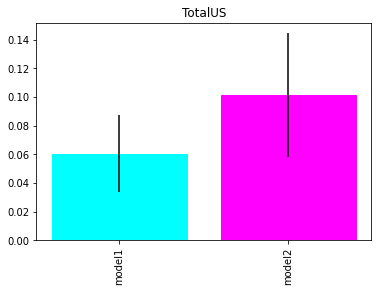

In [30]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###
bar = plt.bar([0,1], [np.mean(mae1_test), np.mean(mae2_test)], 
              yerr=[2.95*np.std(mae1_test), 2.95*np.std(mae2_test)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('TotalUS')

# UNSEEN DATA PREDICTION

In [31]:
### FUNCTION FOR STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
def test_other_drop1(R, typ, enc, NN):
    
    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
    
    enc_pred = np.vstack(enc([X, R]))
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y


def test_other_drop2(R, typ, NN):

    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
    
    XF = np.concatenate([X,F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN([trans_pred, R])
    
    return np.vstack(NN_pred), y

In [32]:
### COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
mae1_other, p1_other = [], []
enc = K.function([encoder.layers[0].input], [encoder.layers[-1].output])
NN = K.function([model1.layers[0].input], [model1.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    pred1_other, true1_other = test_other_drop1(0.5, 'organic', enc, NN)
    mae1_other.append(mean_absolute_error(true1_other, pred1_other))
    p1_other.append(pred1_other)

print(np.mean(mae1_other), np.std(mae1_other))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.36it/s]

0.10021096540889385 0.004585179251507563


In [33]:
### COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY ###
mae2_other, p2_other = [], []
NN = K.function([model2.layers[0].input], [model2.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    pred2_other, true2_other = test_other_drop2(0.5, 'organic', NN)
    mae2_other.append(mean_absolute_error(true2_other, pred2_other))
    p2_other.append(pred2_other)

print(np.mean(mae2_other), np.std(mae2_other))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 105.88it/s]

0.10732099761666718 0.005136688123964688


Text(0.5, 1.0, 'ORGANIC Albany')

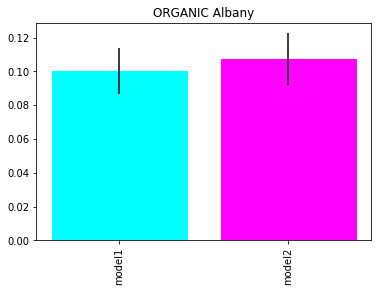

In [34]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###
bar = plt.bar([0,1], [np.mean(mae1_other), np.mean(mae2_other)], 
              yerr=[2.95*np.std(mae1_other), 2.95*np.std(mae2_other)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('ORGANIC Albany')